# Model Evaluation and Output Generation

This notebook outlines the process of loading a pre-trained model and tokenizer, evaluating the model on a dataset, generating outputs based on input steps, and analyzing the results

In [1]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
from collections import defaultdict

from tokenizer import TextDataset  

/home/ubuntu/anaconda3/envs/gpt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/anaconda3/envs/gpt2/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Setup

Define constants for model paths, data files, and device configuration. Ensure that the paths to the model checkpoint and tokenizer are correct for your environment.


In [2]:
# Constants for model, tokenizer, and data paths
MODEL_PATH = './output/MobiGPT-Act-Demographic/checkpoint-2403400'
TOKENIZER_PATH = './PTtokenizer/Tokyo/'  # Update this with the actual path to your tokenizer
DATA_FILE = 'data/Tokyo2008PTChainSummary.txt'  # Path to your evaluation data
ACCURACY_RESULTS_FILE = 'output/accuracy_by_input_length.csv'

MAX_LENGTH = 75 
TOP_K= 10
TOP_P = 0.95
TEMPERATURE = 1.0
EXCLUDED_IDS = [[i] for i in range(24, 56)]  # Token IDs to exclude

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load Model and Tokenizer

Load the pre-trained model and tokenizer using the paths specified above. The model is moved to the appropriate device (GPU or CPU) based on availability.


In [7]:
def load_model_and_tokenizer(model_path, tokenizer_path):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()
    return model, tokenizer

model, tokenizer = load_model_and_tokenizer(MODEL_PATH, TOKENIZER_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Function Defines

In [15]:
def generate_model_output(model, input_ids, max_length=MAX_LENGTH, top_k=TOP_K, top_p=TOP_P, temperature=TEMPERATURE, excluded_ids=EXCLUDED_IDS):
    return model.generate(input_ids, do_sample=True, max_length=max_length, top_p=top_p, temperature=temperature, bad_words_ids=excluded_ids)

In [16]:
def load_eval_dataset(file_path, tokenizer, n_rows=10000):
    return TextDataset(file_path, tokenizer, n_rows=n_rows)

def evaluate_model(model, dataset, input_steps=INPUT_STEPS):
    results = []
    for i, input_data in enumerate(dataset):
        if i % 10 == 0:
            print(f"Evaluating input {i}")
        input_ids = input_data['input_ids'].to(device)[:input_steps].unsqueeze(0)
        output = generate_model_output(model, input_ids)
        results.append(output.squeeze(0))
    return results

Loading Dataset: 10001it [00:02, 3766.77it/s]


Evaluating input 0
Evaluating input 10
Evaluating input 20


KeyboardInterrupt: 

In [ ]:
eval_dataset = load_eval_dataset('data/Tokyo2008PTChainSummary.txt', tokenizer)

## Accuracy Calculation 

Define a function to calculate the accuracy of the model's predictions for different input lengths. This function reads the evaluation data, generates predictions, and compares them to the original tokens to calculate accuracy.

In [3]:
SEQ_LEN = 75 # 0: gender, 1: age, 2: occupation, 3-75: activity sequence
NUM_LINES = 1000

def calculate_accuracy(dataset, tokenizer, model, num_lines=NUM_LINES):
    generated_tokens_by_length = {i: [] for i in range(1, SEQ_LEN)}  
    correct_predictions = {i: 0 for i in range(1, SEQ_LEN)}
    total_lines = 0

    # Iterate over the dataset
    for line_number, data in enumerate(dataset):
        if line_number >= num_lines:  # Stop after processing the specified number of lines
            break
        if line_number % 100 == 0:  # Print progress every 100 lines
            print(f"Processing line {line_number + 1}/{num_lines}")

        total_lines += 1
        original_tokens = input_ids.tolist()  # Convert tensor to list for easier manipulation

        # Iterate through different input lengths to calculate accuracy
        for input_length in range(1, SEQ_LEN):
            input_tokens = input_ids[:input_length].unsqueeze(0)  # Add batch dimension
            with torch.no_grad():  # Disable gradient computation for inference
                outputs = generate_model_output(model, input_tokens, max_length=48)
            generated_tokens = outputs[0][input_length:].tolist()  # Extract generated tokens
            generated_tokens_by_length[input_length].append(generated_tokens)

            # Compare generated tokens with the original tokens
            correct_tokens = original_tokens[input_length:SEQ_LEN]
            accuracy_count = sum(1 for i, j in zip(generated_tokens, correct_tokens) if i == j)
            correct_predictions[input_length] += accuracy_count / len(correct_tokens)

    # Calculate and print average accuracy for each input length
    accuracies = {length: correct / total_lines for length, correct in correct_predictions.items()}
    for input_length, accuracy in accuracies.items():
        print(f"Input Length: {input_length}, Average Accuracy: {accuracy:.4f}")

    return pd.DataFrame(list(accuracies.items()), columns=['Input Length', 'Average Accuracy']), generated_tokens_by_length

In [10]:
accuracies, generated_tokens = calculate_accuracy(DATA_FILE, tokenizer, model)

Processing line 1/300



KeyboardInterrupt



# Hourly Activity Distribution

In [50]:
input_steps = 12 # replace the input step number from 1~12 or even longer to check the difference 
excluded_ids = [[i] for i in range(24, 56)] # mask token_ids such as age, gender, occupation in generating activities
results = []

i = 0

for input in eval_dataset:
    if i % 10 == 0:
        print(i)
    input = input['input_ids'].to(device)
    input_ids = input[:input_steps].unsqueeze(0)
    output = model.generate(input_ids, do_sample=True,
                    max_length=75,
                    # top_k=15,
                    top_p=0.95,
                    temperature=1.0,
                    bad_words_ids=excluded_ids)
    # output = generate_activities(model, input_ids, excluded_ids, max_length=75, top_k=10, top_p=0.9, temperature=0.8)
    results.append(output.squeeze(0))
    i += 1 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

## Count hourly acitivity distribution

In [53]:
START = 0 # 0 gender, 1 age, 2 occupation, start from 
END = 75  # 6:00~24:00 in 15 minutes step
STEP = 1 # step=4 means only count on the hour. 1~4 is OK
INPUT_STEPS = 12

results = generated_tokens[INPUT_STEPS]

original_t = {j: defaultdict(int) for j in range(START, END, STEP)} 
generated_t = {j: defaultdict(int) for j in range(START, END, STEP)}

for i in range(len(eval_dataset)):
    input_ids = eval_dataset[i]['input_ids']
    results_i = results[i]
    
    for j in range(start, end, step):
        original_token = tokenizer.decode(input_ids[j].item())
        generated_token = tokenizer.decode(results_i[j].item())
        
        original_t[j][original_token] += 1
        generated_t[j][generated_token] += 1

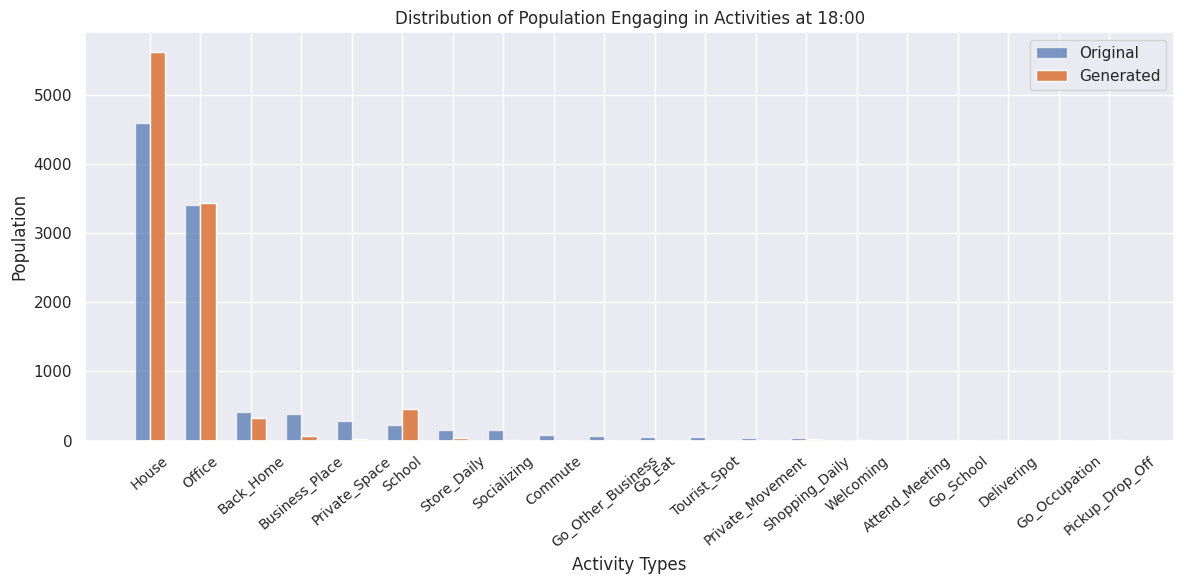

In [47]:
j_value = 48 # set the time here

original_counts = original_t[j_value]
generated_counts = generated_t[j_value]

all_tokens = set(original_counts.keys()) | set(generated_counts.keys())


original_frequencies = [original_counts.get(token, 0) for token in all_tokens] 
generated_frequencies = [generated_counts.get(token, 0) for token in all_tokens] 
tokens = list(all_tokens)

sorted_indices = np.argsort(original_frequencies)[::-1]
original_frequencies = [original_frequencies[i] for i in sorted_indices]
generated_frequencies = [generated_frequencies[i] for i in sorted_indices]
tokens = [tokens[i] for i in sorted_indices]

sns.set()

x = np.arange(len(tokens))
width = 0.3

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, original_frequencies, width, label='Original', alpha=0.7)
plt.bar(x + width/2, generated_frequencies, width, label='Generated')
plt.xlabel('Activity Types')
plt.ylabel('Population')
plt.title(f'Distribution of Population Engaging in Activities at {int(6+j_value /4)}:00')
plt.xticks(x, tokens, rotation=40, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

## Examine the Generated Activity Sequence Patterns

In [88]:
from collections import defaultdict

def extract_unique_patterns(sequence):
    unique_patterns = []
    current_pattern = []
    for token in sequence:
        if not current_pattern or token != current_pattern[-1]:
            current_pattern.append(token.item())
    unique_patterns.append(tuple(current_pattern))
    return unique_patterns

# Initialize a dictionary to store patterns for each occupation
occupation_patterns = defaultdict(list)

# Iterate over the results list
for result in results:
    # Extract occupation from the third element
    occupation = result[2].item()
    
    # Extract patterns from the sequence starting from the 4th element
    patterns = extract_unique_patterns(result[3:])
    
    # Convert patterns to string representation
    pattern_str = ''.join(str(token) for token in patterns[0])
    
    # Append pattern to the list of patterns for the corresponding occupation
    occupation_patterns[occupation].append(pattern_str)

# Define the matching table for occupation and patterns
occupation_mapping = {
    '0': 'NaN',
    '1': "House",
    '2': "Commute",
    '3': "Office",
    '4': "Go_School",
    '5': "School",
    '6': "Back_Home",
    '7': "Attend_Meeting",
    '8': "Go_Occupation",
    '9': "Delivering",
    '10': "Go_Other_Business",
    '11': "Business_Place",
    '12': "Private_Movement",
    '13': "Private_Space",
    '14': "Go_Eat",
    '15': "Socializing",
    '16': "Shopping_Daily",
    '17': "Store_Daily",
    '18': "Welcoming",
    '19': "Pickup_Drop_Off",
    '20': "Go_Sightseeing",
    '21': "Tourist_Spot",
    '22': "Natural_Area",
    '23': "Office_Worker",
    '24': "Technical_Worker",
    '25': "Service_Worker",
    '26': "Managerial_Worker",
    '27': "Sales_Worker",
    '28': "Security_Worker",
    '29': "Go_Agricultural_Work",
    '30': "Agriculture_Worker",
    '31': "Labor_Worker",
    '32': "Traffic_Worker",
    '33': "Other_Occupation",
    '34': "Student",
    '35': "Housewife",
    '36': "Unemployed",
    '37': "Unclear"
}

# Initialize a dictionary to store pattern ratios for each occupation
occupation_pattern_ratios = defaultdict(dict)

# Calculate pattern ratios for each occupation
for occupation, patterns in occupation_patterns.items():
    pattern_counts = Counter(patterns)
    total_patterns = len(patterns)
    pattern_ratios = {tuple(occupation_mapping[token] for token in pattern): count / total_patterns for pattern, count in pattern_counts.items()}
    occupation_pattern_ratios[occupation_mapping[str(occupation)]] = pattern_ratios

# Print occupation pattern ratios
for occupation, pattern_ratios in occupation_pattern_ratios.items():
    print(f"Occupation: {occupation}")
    for pattern, ratio in pattern_ratios.items():
        print(f"Pattern: {pattern}, Ratio: {ratio:.2f}")
    print()


Occupation: Service_Worker
Pattern: ('House', 'Commute', 'Office', 'Back_Home', 'House'), Ratio: 0.43
Pattern: ('House',), Ratio: 0.40
Pattern: ('House', 'Delivering', 'House', 'House', 'Back_Home', 'House'), Ratio: 0.00
Pattern: ('House', 'Commute', 'Office', 'Back_Home'), Ratio: 0.03
Pattern: ('House', 'Commute', 'Office', 'House', 'Back_Home', 'House', 'Attend_Meeting', 'House'), Ratio: 0.00
Pattern: ('House', 'Commute', 'Office'), Ratio: 0.02
Pattern: ('House', 'House', 'Back_Home', 'House'), Ratio: 0.00
Pattern: ('Office', 'Back_Home', 'House'), Ratio: 0.02
Pattern: ('House', 'Delivering', 'House', 'House'), Ratio: 0.00
Pattern: ('House', 'House', 'Delivering', 'Commute', 'Office', 'Back_Home'), Ratio: 0.00
Pattern: ('House', 'Office', 'Back_Home', 'House'), Ratio: 0.01
Pattern: ('Commute', 'Office', 'Back_Home', 'House'), Ratio: 0.01
Pattern: ('House', 'Office', 'House'), Ratio: 0.02
Pattern: ('House', 'House', 'Go_School', 'House', 'School', 'Back_Home', 'House', 'House', 'Go_Sc

In [89]:
# Create a list to store occupation, pattern, and ratio
data = []

# Iterate over occupation pattern ratios
for occupation, pattern_ratios in occupation_pattern_ratios.items():
    for pattern, ratio in pattern_ratios.items():
        data.append([occupation, pattern, ratio])

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Occupation', 'Pattern', 'Ratio'])

# Display the DataFrame
print(df)


         Occupation                                            Pattern  \
0    Service_Worker         (House, Commute, Office, Back_Home, House)   
1    Service_Worker                                           (House,)   
2    Service_Worker  (House, Delivering, House, House, Back_Home, H...   
3    Service_Worker                (House, Commute, Office, Back_Home)   
4    Service_Worker  (House, Commute, Office, House, Back_Home, Hou...   
..              ...                                                ...   
432    Labor_Worker  (House, Commute, Office, House, Delivering, Of...   
433    Labor_Worker          (Office, Back_Home, House, Office, House)   
434    Labor_Worker  (House, Back_Home, Office, Go_Occupation, Hous...   
435    Labor_Worker  (House, House, NaN, Go_Occupation, House, Hous...   
436    Labor_Worker  (House, Commute, House, Office, Back_Home, Hou...   

        Ratio  
0    0.432526  
1    0.401384  
2    0.003460  
3    0.025375  
4    0.004614  
..        ...  

In [94]:
# Filter the DataFrame for selected occupations
selected_occupations = ['Office_Worker', 'Student', 'Housewife', 'Unemployed']
selected_df = df[df['Occupation'].isin(selected_occupations)]

# Select the top 5 patterns for each occupation
top_patterns = selected_df.groupby('Occupation').apply(lambda x: x.nlargest(5, 'Ratio')).reset_index(drop=True)

# Display the top patterns table
print(top_patterns)

       Occupation                                            Pattern     Ratio
0       Housewife                                           (House,)  0.796460
1       Housewife  (House, House, Back_Home, House, Attend_Meetin...  0.127112
2       Housewife  (House, House, Commute, House, Office, Back_Ho...  0.019308
3       Housewife  (House, House, Back_Home, House, Attend_Meetin...  0.010459
4       Housewife              (House, House, Attend_Meeting, House)  0.009654
5   Office_Worker         (House, Commute, Office, Back_Home, House)  0.665221
6   Office_Worker                                           (House,)  0.186551
7   Office_Worker  (House, Commute, Office, House, Back_Home, Hou...  0.039046
8   Office_Worker  (House, Commute, Office, House, Back_Home, Hou...  0.015184
9   Office_Worker                (House, Commute, Office, Back_Home)  0.013738
10        Student       (House, Go_School, School, Back_Home, House)  0.712519
11        Student                                   

/tmp/ipykernel_16627/420768977.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_patterns = selected_df.groupby('Occupation').apply(lambda x: x.nlargest(5, 'Ratio')).reset_index(drop=True)


In [96]:
top_patterns.to_csv('top_patterns.csv', index=False)